In [54]:
import numpy as np
from numpy.fft import rfft,irfft,fftshift
import os
from os.path import join as pathjoin
import matplotlib.pyplot as plt
import h5py
import json
import scipy
from scipy.optimize import curve_fit
from scipy.signal.windows import nuttall,hann,tukey,cosine,bartlett,blackman

# Cust window
flat=np.ones
all_windows={"nuttall":nuttall,
             "hann":hann,
             "tukey":tukey,
             "cosine":cosine,
             "flat":flat,
             "bartlett":bartlett,
             "blackman":blackman}
sqrt=np.sqrt
mean=np.mean

In [2]:
root="./LOSC_Event_tutorial/"

In [3]:
def read_template(fname):
    data_file=h5py.File(fname,'r')
    template=data_file['template']
    tp,tx=template[0],template[1]
    return tp,tx

In [4]:
def read_file(fname):
    data_file=h5py.File(fname,'r')
    dq_info=data_file['quality']['simple']
    qmask=dq_info['DQmask'][...]
    meta=data_file['meta']
    gps_start=meta['GPSstart'][()]
    utc=meta['UTCstart'][()]
    duration=meta['Duration'][()]
    strain=data_file['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)
    data_file.close()
    return strain,dt,utc

In [5]:
# # Taken from Jon's class code
# def cos_window(n:int):
#     """returns cosine window of size n"""
#     x=np.linspace(-np.pi,np.pi,n)
#     return 0.5+0.5*np.cos(x)


In [6]:
# Load events info
# ----------------
# Load event metadata
events=json.load(open(pathjoin(root,'BBH_events_v3.json')))
# # Fill dictionaries with all we need
# hanford={}    # hanford detector data
# livingston={} # livingston detector data
# for e in events:
#     # Hanford detector params
#     strain,dt,utc = read_file(pathjoin(root,events[e]['fn_H1']))
#     hanford[e]={"strain":strain,"dt":dt,"utc":utc}
#     # Livingston detector params
#     strain,dt,utc = read_file(pathjoin(root,events[e]['fn_L1']))
#     livingston[e]={"strain":strain,"dt":dt,"utc":utc}
# # Load events


In [7]:
def get_psd(arr,window=None):
    """Get the psd of a real array, optionally takes window func"""
    if window is not None:
        w_arr=window(len(arr)) # make window array
        arr_ft=rfft(arr*w_arr)
    else:
        arr_ft=rfft(arr)
    psd=np.abs(arr_ft)**2
    return psd

# def smooth(arr,size:int,window):
#     """takes array, window and size, makes kernel and convolves"""
#     ker=window(size)
#     return np.convolve(arr,ker,mode='same')

In [8]:
# def match_filt(d,A,rftN):
#     """returns matched filter, relative most-likely amplitude
#     d : ndarray
#         data
#     A : ndarray
#         template
#     rftN : ndarray
#         Stationary noise, i.e. the PSD
#     """
#     rft_f=np.conj(rfft(A))*rfft(d)/rftN
#     return irfft(rft_f)

def match_filt(data,template,ker):
    """
    data : 1d array, already windowed data
    template : 1d array same shape as data
    ker is the smoothing kernel
    """
    assert len(data)==len(template),"data must be same shape as template"
    psd=np.abs(rfft(data))**2 # stationary noise model
    psd=np.convolve(psd,ker,'same') # smooth the psd
    # Perform correlation inversly weighted by psd
    amplitude_ft=np.conj(rfft(template))*rfft(data)/psd
    return irfft(amplitude_ft)

In [9]:
def get_curvature(data,template,ker):
    """make sure to window the tamplate?"""
    psd=np.abs(rfft(data))**2
    psd=np.convolve(psd,ker,'same') # smooth the psd
    ANhalf = rfft(template)/np.sqrt(psd)
    c = irfft(ANhalf)
    return c@c

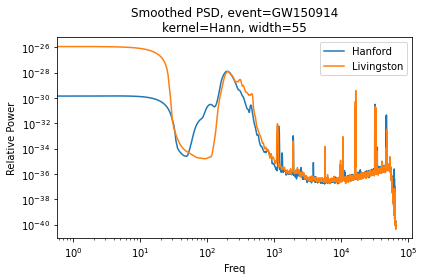

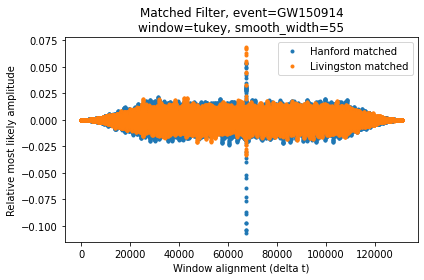

GW150914
SNR analitic estimate hanford/livingston=69.37/25.57
SNR measured estimate hanford/livingston=17.53/12.91


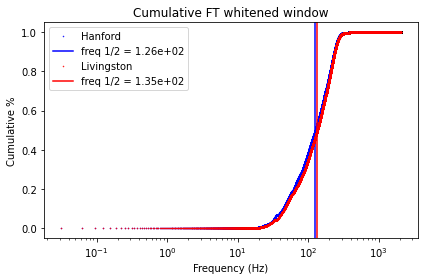

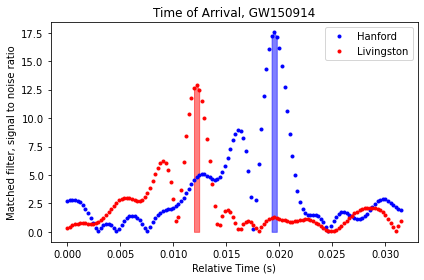

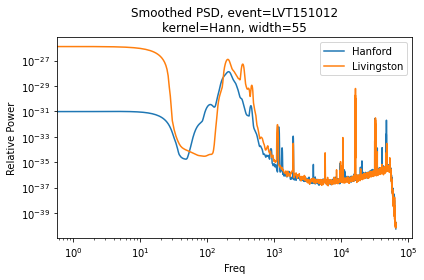

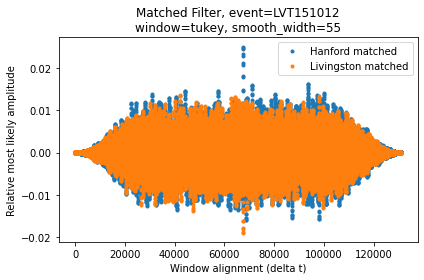

LVT151012
SNR analitic estimate hanford/livingston=18.68/16.95
SNR measured estimate hanford/livingston=6.26/5.18


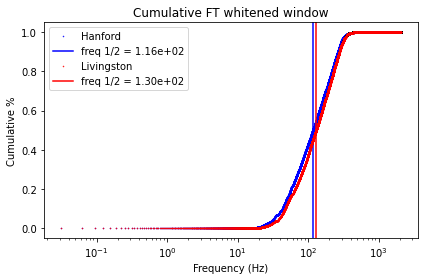

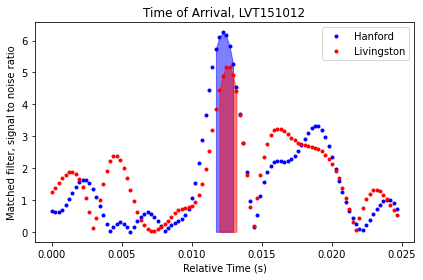

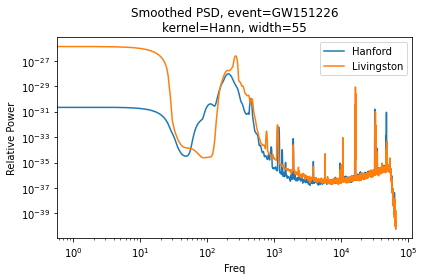

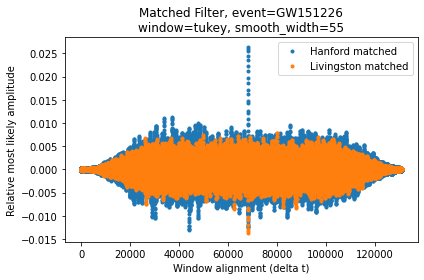

GW151226
SNR analitic estimate hanford/livingston=5.03/3.43
SNR measured estimate hanford/livingston=9.76/6.88


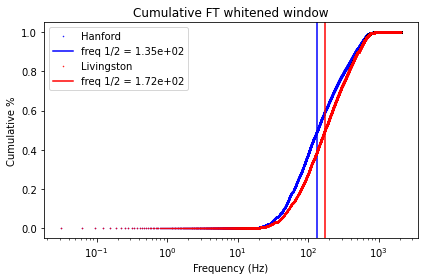

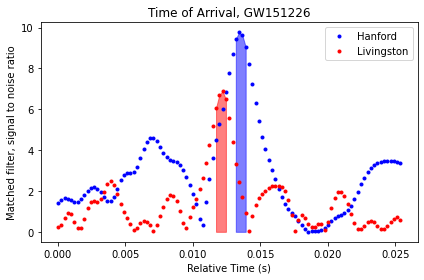

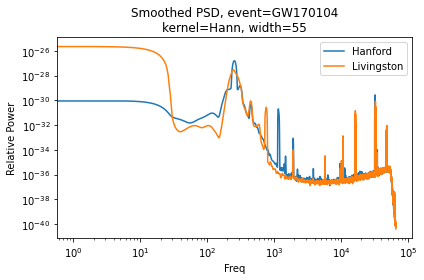

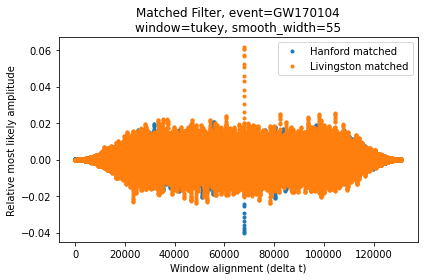

GW170104
SNR analitic estimate hanford/livingston=22.82/34.51
SNR measured estimate hanford/livingston=8.25/9.62


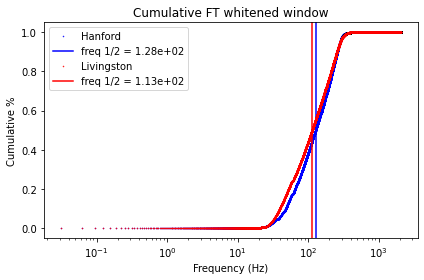

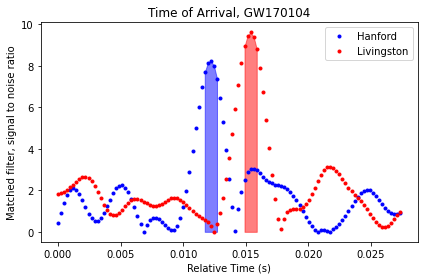

In [110]:
window_name="tukey"
window=all_windows[window_name]#hann # Select a windowing function to prevent leaking
width_smooth=55 # The width of the smoothing kernel
ker,ker_name=hann(width_smooth),"Hann" # smoothing kernel is window(width)
smooth = lambda x:np.convolve(x,ker,'same') # smoothing funciton

for e in events:
    ### (a)
    # Load Hanford data
    strain_h,dt_h,utc_h = read_file(pathjoin(root,events[e]['fn_H1']))
    win = window(len(strain_h)) # len(strain_h)==len(strain_l)==len(tp)
    strain_h *= win #window(len(strain_h))
    psd_h=get_psd(strain_h) # Hanford PSD
    # Load Livingston data
    strain_l,dt_l,utc_l = read_file(pathjoin(root,events[e]['fn_L1']))
    strain_l *= win #window(len(strain_l))
    psd_l=get_psd(strain_l) # Livingston PSD
    # Plot them and compare (ommited)
    
    # Smooth and plot the PSDs
    plt.figure()
    # plt.loglog(smoothed_psd[480:-10000])
    plt.loglog(smooth(psd_h),label="Hanford")
    plt.loglog(smooth(psd_l),label="Livingston")
    plt.title(f"Smoothed PSD, event={e}\nkernel={ker_name}, width={width_smooth}")
    plt.legend()
    plt.xlabel("Freq")
    plt.ylabel("Relative Power")
    plt.tight_layout()
    plt.savefig(f"img/p5_smoothed_psd_{e}.png",dpi=450)
    plt.show()
    
    ### (b)
    # Load templates into variables
    tp,tx = read_template(pathjoin(root,events[e]['fn_template']))
    tp_win = tp*window(len(tp)) # Window template, we only use tp, not tx
    tp_psd = np.abs(rfft(tp_win)**2) # Get PSD of template
    
    # Noise models
    ninv_h = 1/smooth(psd_h) # hanford N inv 
    ninv_l = 1/smooth(psd_l) # Livingston N inv
    
    # Whiten the strains and template
    sftwhite_h = sqrt(ninv_h)*rfft(strain_h) # whitend hanford strain FT
    sftwhite_l = sqrt(ninv_l)*rfft(strain_l) # whitend livingston strain FT
    tpftwhite_h = sqrt(ninv_h)*rfft(tp*window(len(tp)))# template whitned with Hanford noise model
    tpftwhite_l = sqrt(ninv_l)*rfft(tp*window(len(tp)))# template whitned with Livingston noise model
    
    # Matched filters
    mh = irfft(np.conj(tpftwhite_h) * sftwhite_h) # Hanford matched filter
    ml = irfft(np.conj(tpftwhite_l) * sftwhite_l) # Livingston matched filter
    
    
    # Plot the matched filters
    plt.figure()
    plt.title(f"Matched Filter, event={e}\nwindow={window_name}, smooth_width={width_smooth}")
    plt.plot(fftshift(mh),".",linewidth=0.1,label="Hanford matched")
    plt.plot(fftshift(ml),".",linewidth=0.1,label="Livingston matched")
    plt.legend()
    plt.xlabel("Window alignment (delta t)")
    plt.ylabel("Relative most likely amplitude")
    plt.tight_layout()
    plt.savefig(f"img/p5_matched_filter_{e}.png",dpi=450)
    plt.show()
    
    ### (c) , (d)
    # Estimate noise analytically
    AtNinvA_h = 2*abs(tpftwhite_h@tpftwhite_h) # factor of 2 from rfft
    AtNinvA_l = 2*abs(tpftwhite_l@tpftwhite_l) # factor of 2 from rfft
        
    # Estimate signal to noise ratio
    snr_anal_h = max(abs(mh))*sqrt(AtNinvA_h) # signal to noise analytic hanford
    snr_anal_l = max(abs(ml))*sqrt(AtNinvA_l) # " Livingston
    snr_esti_h = max(abs(mh))/np.std(mh[:35000]) # std is power since mean is zero
    snr_esti_l = max(abs(ml))/np.std(ml[:35000]) # std is power since mean is zero
    
    # Display SNR estimates
    print(f"{e}")
    print(f"SNR analitic estimate hanford/livingston={snr_anal_h:.2f}/{snr_anal_l:.2f}")
    print(f"SNR measured estimate hanford/livingston={snr_esti_h:.2f}/{snr_esti_l:.2f}")

    ### (e)
    # Get frequency array
    sr = 1/dt_l # sample rate, assume same for Livingston and Hanford
    nyquist = sr/2 # nyquist frequency
    freqs = np.linspace(0,nyquist,len(strain_l)//2+1)
    # Plot the FT of 
    plt.figure(figsize=(6,4))
    plt.title(f"Cumulative FT whitened window")
    # Hanford
    # Cumulative hanford FT white
    tpwhite_cum_h = np.cumsum(abs(tpftwhite_h))/sum(abs(tpftwhite_h))
    # The frequency where half the weight is above, half below
    freqhalf_h = freqs[np.argwhere(tpwhite_cum_h>0.5).min()]
    plt.semilogx(freqs[1:],tpwhite_cum_h[1:],"b.",
                 markersize=1,label=f"Hanford")
    plt.axvline(freqhalf_h,color="blue",label=f"freq 1/2 = {freqhalf_h:.2e}")
    # Livingston
    # The frequency where half the weight is above, half below
    tpwhite_cum_l = np.cumsum(abs(tpftwhite_l))/sum(abs(tpftwhite_l))
    freqhalf_l = freqs[np.argwhere(tpwhite_cum_l>0.5).min()]
    plt.semilogx(freqs[1:],tpwhite_cum_l[1:],"r.",
                markersize=1,label="Livingston")
    plt.axvline(freqhalf_l,color="red",label=f"freq 1/2 = {freqhalf_l:.2e}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Cumulative %")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"img/p5_cumulative{e}.png",dpi=450)
    plt.show()
    
    ### (f)
    # Zoom in to peak and plot it
    peak_idx_h = np.argmax(abs(mh)) # the GW peak detection
    peak_idx_l = np.argmax(abs(ml)) # the GW peak detection
    mini,maxi = min(peak_idx_h,peak_idx_l),max(peak_idx_h,peak_idx_l)
    idxs = np.arange(mini-50,maxi+50) # 'plot-range' the range of values to plot
    # time = np.linspace(0,dt_l*(len(strain_h)-1),len(strain_h))
    alltime = np.linspace(0,dt_l*(len(strain_h)-1),len(strain_h))
    reltime = alltime[idxs]
    r0      = reltime[0]
    reltime-= r0
#     reltime = np.linspace(0,dt_l*(len(idxs)-1),len(idxs)) # relative times
    
    # Signal to noise ratio arrays
    snr_h = abs(mh)/np.std(mh[:35000])
    snr_l = abs(ml)/np.std(ml[:35000])
    # Estimate uncertainty in peak time
    bin_h = np.argwhere((max(snr_h) - snr_h)<1.0).squeeze()
    sigma_h = len(bin_h)*dt_h
    bin_l = np.argwhere((max(snr_l) - snr_l)<1.0).squeeze()
    sigma_l = len(bin_l)*dt_l
    
    # Plot the Time of arrivals
    plt.figure()
    plt.title(f"Time of Arrival, {e}")
    plt.xlabel("Relative Time (s)")
    plt.ylabel("Matched filter, signal to noise ratio")
    plt.plot(reltime,snr_h[idxs],"b.",label="Hanford")
    plt.fill_between(alltime[bin_h]-r0,snr_h[bin_h],color="b",alpha=0.5)
    plt.plot(reltime,snr_l[idxs],"r.",label="Livingston")
    plt.fill_between(alltime[bin_l]-r0,snr_l[bin_l],color="r",alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"img/arrival_times_{e}.png",dpi=450)
    plt.show()
    
    # faulty first attempt
#     ### (c) Signal to noise ratio
#     sig_power_h = max(matched_h**2) # estimate of signal
#     noise_power_h = np.mean(matched_h[:35000]**2) # estimate the noise, quick & dirty
#     # trunkate to not let tukey window affect our power estimate
#     # 35000 data is enough...
#     snr_h = sig_power_h/noise_power_h
#     sig_power_l = max(matched_l**2) # estimate of signal
#     noise_power_l = np.mean(matched_l[:35000]**2) # estimate the noise, quick & dirty
#     snr_l = sig_power_l/noise_power_l
#     snr = snr_l + snr_h
    
#     print(f"{e} SNR Hanford {snr_h}")
#     print(f"{e} SNR Livingston {snr_l}")
#     print(f"{e} SNR Combined {snr}")
    
    ### (d) curvature
    
#     curvature_h = get_curvature(strain_h,template_h,ker)
#     print("\nCurvature calculated")
#     print(f"{e} Curvature Hanford {curvature_h}")
#     print(f"{e} SNR Hanford")
    
    
    
    

## All windows

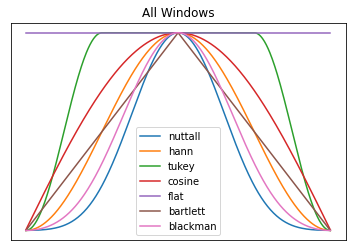

In [11]:
for name,w in all_windows.items():
    plt.plot(w(500),label=name)
plt.legend()
plt.title("All Windows")
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.show()